In [18]:
import math
import numpy as np
import re
import random
import os

from collections import Counter
from matplotlib import pyplot as plt
from PIL import Image

In [19]:
os.listdir('train-letters/0')

['A_10.png',
 'A_12.png',
 'A_6.png',
 'A_1.png',
 'A_13.png',
 'A_3.png',
 'A_4.png',
 'A_15.png',
 'A_5.png',
 'A_9.png',
 'A_7.png',
 'A_8.png',
 'A_2.png',
 'A_0.png',
 'A_14.png',
 'A_11.png']

In [20]:
## Split each image into four segments of 120px width
# Labelling scheme: A-Z are 0-25 and 0-9 are 26-35
def labelFromChar(ch):
  if (ch >= 'A' and ch <= 'Z'):
    return ord(ch) - ord('A')
  else:
    return 26 + ord(ch) - ord('0')

def charFromLabel(label):
  if (label >= 0 and label <= 25):
    return chr(label + ord('A'))
  else:
    return chr(label - 26 + ord('0'))

# Overfit testing

In [21]:
# Overfit test
img_folder = 'train-letters'
letter_set = []
letter_train_set = []
letter_val_set = []
for i in range(26):
    all_i = []
    img_files = os.listdir(f'{img_folder}/{i}')
    letter = chr(ord('A') + i)
    j = 0
    for img_file in img_files:
        # print(img_file)
        img = np.array(Image.open(os.path.join(img_folder, str(i), img_file)))
        # pick 25% of images for the validation set
        all_i.append(img)
    # Pick 25% as validation
    val_indices = set(random.sample(range(len(all_i)), k=len(all_i)//4))
    for j in range(len(all_i)):
        letter_set.append((all_i[j], i))
        if j in val_indices:
            letter_val_set.append((all_i[j], i))
        else:
            letter_train_set.append((all_i[j], i))

    
print(f"Loaded {len(letter_set)} images from folder:\n{img_folder}")
print(f'{len(letter_train_set)} training, {len(letter_val_set)} validation')

Loaded 416 images from folder:
train-letters
312 training, 104 validation


In [22]:
all_dataset = letter_set
train_dataset = letter_train_set
val_dataset = letter_val_set
# Shuffle the dataset
np.random.shuffle(train_dataset)
np.random.shuffle(all_dataset)
X_dataset_all_orig = np.array([data[0] for data in all_dataset])
Y_dataset_all_orig = np.array([data[1] for data in all_dataset])
X_dataset_train_orig = np.array([data[0] for data in train_dataset])
Y_dataset_train_orig = np.array([data[1] for data in train_dataset])
X_dataset_val_orig = np.array([data[0] for data in val_dataset])
Y_dataset_val_orig = np.array([data[1] for data in val_dataset])
print(Y_dataset_train_orig)

[11 18 23 20  6 23  2  6  6  7 22 21  7  5 25 11 19  1 17 12 10  5  4 10
 19 20 24 16  0  2  3 11  5  9 13 18 17  9  1 13  0 18 14  5 21 12  7 18
 16 16  7  3 10 13 12 19 21  9  3  3  4  9 13 23  0 24  5  6 11 21 20 16
  8 14 22 22 16  7 23  7 17  1 10  2 23  9 18 22  6 25  9 19 11 16 14 11
  1  3 13 14  6  4 20 14 25 21  3  6 22 21 12 15 11 19 19  1  8  8 12 23
 10  1 24 14  0 15 23  3 15 14 25  7 25 17 22 22 20  2  2 22  7  1  8  1
 25 22 24 11  0 10 22  3 13 24  3 18 13  0 24  2  0 19 15  4 23  4 15 13
 12  2  7 10 23 24 16 16 16  4  9  8 17 10  6 19 15  7 21 18  6 24 13 12
 20  5 17 20 12  0  3 15 20 23 17 20 21 10 11 13 20 15 15 21 20  4  4 24
 11 14 19  2  7 12 19 11 15  7  2  5  8  8 11 12  8  6  0  8 16 17  5 25
  9  3  5 15 20 18  4  2 24 17 17  0 25 14 17 23 15 25  1 22 21 19 25  4
 12  5  0 18 22  3 18 25 17  8  9 24 19 13 21  5  2 25  6  1  5 13 24 16
 14 10  4  4  6 16  2 18  0 23 10  8  1 18  9  9  1 10  8 21  9 14 12 14]


In [23]:
type(Y_dataset_val_orig[0])

numpy.int64

In [24]:
NUMBER_OF_LABELS = 26
CONFIDENCE_THRESHOLD = 0.01

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

convert_to_one_hot(Y_dataset_all_orig, 26)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [25]:
NUMBER_OF_LABELS = 26
CONFIDENCE_THRESHOLD = 0.01

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

# Normalize X (images) dataset (8 bit value 0..255 converted to float 0..1)
X_dataset_all = X_dataset_all_orig/255.
X_dataset_train = X_dataset_train_orig/255.
X_dataset_val = X_dataset_val_orig/255.

# Convert Y dataset to one-hot encoding
Y_dataset_all = convert_to_one_hot(Y_dataset_all_orig, NUMBER_OF_LABELS).T
Y_dataset_train = convert_to_one_hot(Y_dataset_train_orig, NUMBER_OF_LABELS).T
Y_dataset_val = convert_to_one_hot(Y_dataset_val_orig, NUMBER_OF_LABELS).T

print(Y_dataset_train[0]) # Check if matches the first label in Y_dataset_orig
print(Y_dataset_train[-1]) # Check if matches the last label in Y_dataset_orig

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


None of this is our true test dataset. Model performance needs to be tested on actual SIFTed images, but that will come later.

In [26]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend

In [27]:
def reset_weights(model):
  for ix, layer in enumerate(model.layers):
      if (hasattr(model.layers[ix], 'kernel_initializer') and
          hasattr(model.layers[ix], 'bias_initializer')):
          weight_initializer = model.layers[ix].kernel_initializer
          bias_initializer = model.layers[ix].bias_initializer

          old_weights, old_biases = model.layers[ix].get_weights()

          model.layers[ix].set_weights([
              weight_initializer(shape=old_weights.shape),
              bias_initializer(shape=len(old_biases))])

In [28]:
LETTER_DIM_Y = 80
LETTER_DIM_X = 64
X_dataset_val[0].shape

(80, 64)

In [29]:
conv_model = models.Sequential()
conv_model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu',
                             input_shape=(LETTER_DIM_Y, LETTER_DIM_X, 1)))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
conv_model.add(layers.MaxPooling2D((2, 2)))
# Lines commented out to match the simpler lecture (Week 5) Keras code example
# conv_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# conv_model.add(layers.MaxPooling2D((2, 2)))
# conv_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Flatten())
conv_model.add(layers.Dropout(0.5))
conv_model.add(layers.Dense(64, activation='relu'))
conv_model.add(layers.Dense(NUMBER_OF_LABELS, activation='softmax'))
conv_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 80, 64, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 40, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 40, 32, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 20, 16, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 20480)             0         
                                                                 
 dropout_1 (Dropout)         (None, 20480)            

 dense_2 (Dense)             (None, 64)                1310784   
                                                                 
 dense_3 (Dense)             (None, 26)                1690      
                                                                 
Total params: 1,331,290
Trainable params: 1,331,290
Non-trainable params: 0
_________________________________________________________________


In [30]:
LEARNING_RATE = 1e-4
conv_model.compile(loss='categorical_crossentropy',
                   optimizer=optimizers.RMSprop(learning_rate=LEARNING_RATE),
                   metrics=['acc'])

In [31]:
reset_weights(conv_model)

In [32]:
history_conv = conv_model.fit(X_dataset_train, Y_dataset_train,
                              validation_data=(X_dataset_val, Y_dataset_val),
                              epochs=25,
                              batch_size=16)

# We can also run the training by specifiying the validation split directly.
#history_conv = conv_model.fit(X_dataset, Y_dataset,
#                              validation_split=VALIDATION_SPLIT,
#                              epochs=20,
#                              batch_size=16)

Epoch 1/25


20/20 [==============================] - 1s 40ms/step - loss: 3.1427 - acc: 0.0897 - val_loss: 2.8766 - val_acc: 0.3558
Epoch 2/25
20/20 [==============================] - 1s 30ms/step - loss: 2.7010 - acc: 0.3109 - val_loss: 2.2967 - val_acc: 0.5096
Epoch 3/25
20/20 [==============================] - 1s 32ms/step - loss: 2.1113 - acc: 0.5224 - val_loss: 1.6724 - val_acc: 0.7115
Epoch 4/25
20/20 [==============================] - 1s 29ms/step - loss: 1.5047 - acc: 0.7308 - val_loss: 1.1470 - val_acc: 0.8462
Epoch 5/25
20/20 [==============================] - 1s 25ms/step - loss: 0.9566 - acc: 0.8718 - val_loss: 0.7009 - val_acc: 0.9135
Epoch 6/25
20/20 [==============================] - 1s 25ms/step - loss: 0.5869 - acc: 0.9327 - val_loss: 0.4262 - val_acc: 0.9231
Epoch 7/25
20/20 [==============================] - 1s 29ms/step - loss: 0.3471 - acc: 0.9808 - val_loss: 0.2822 - val_acc: 0.9327
Epoch 8/25
20/20 [==============================] - 1s 27ms/step - loss: 0.2204 - acc: 0.9808 

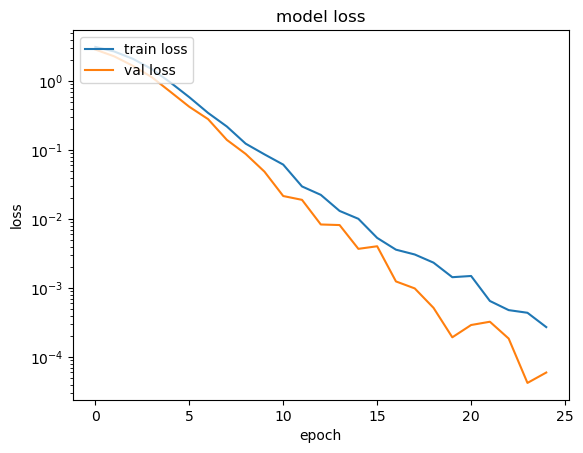

In [33]:
plt.semilogy(history_conv.history['loss'])
plt.semilogy(history_conv.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'], loc='upper left')
plt.show()

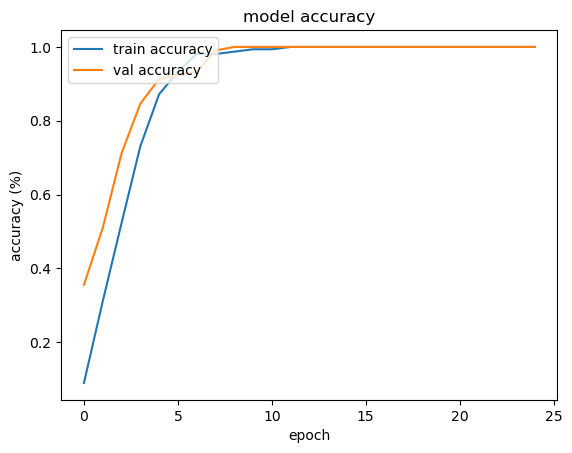

In [34]:
plt.plot(history_conv.history['acc'])
plt.plot(history_conv.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy (%)')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'val accuracy'], loc='upper left')
plt.show()

### Validation loss

In [35]:
import sklearn.metrics
labels = [chr(ascii) for ascii in range(ord('A'), ord('Z') + 1)]
print(labels)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [36]:
true_y = np.argmax(Y_dataset_val, axis=1)
pred_y_prob = conv_model.predict(X_dataset_val, verbose=2)
pred_y = np.argmax(pred_y_prob, axis=1)
true_y_orig = [charFromLabel(label) for label in true_y]
pred_y_orig = [charFromLabel(label) for label in pred_y]
print(true_y_orig)
print(pred_y_orig)

4/4 - 0s - 95ms/epoch - 24ms/step
['A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'C', 'C', 'C', 'C', 'D', 'D', 'D', 'D', 'E', 'E', 'E', 'E', 'F', 'F', 'F', 'F', 'G', 'G', 'G', 'G', 'H', 'H', 'H', 'H', 'I', 'I', 'I', 'I', 'J', 'J', 'J', 'J', 'K', 'K', 'K', 'K', 'L', 'L', 'L', 'L', 'M', 'M', 'M', 'M', 'N', 'N', 'N', 'N', 'O', 'O', 'O', 'O', 'P', 'P', 'P', 'P', 'Q', 'Q', 'Q', 'Q', 'R', 'R', 'R', 'R', 'S', 'S', 'S', 'S', 'T', 'T', 'T', 'T', 'U', 'U', 'U', 'U', 'V', 'V', 'V', 'V', 'W', 'W', 'W', 'W', 'X', 'X', 'X', 'X', 'Y', 'Y', 'Y', 'Y', 'Z', 'Z', 'Z', 'Z']
['A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'C', 'C', 'C', 'C', 'D', 'D', 'D', 'D', 'E', 'E', 'E', 'E', 'F', 'F', 'F', 'F', 'G', 'G', 'G', 'G', 'H', 'H', 'H', 'H', 'I', 'I', 'I', 'I', 'J', 'J', 'J', 'J', 'K', 'K', 'K', 'K', 'L', 'L', 'L', 'L', 'M', 'M', 'M', 'M', 'N', 'N', 'N', 'N', 'O', 'O', 'O', 'O', 'P', 'P', 'P', 'P', 'Q', 'Q', 'Q', 'Q', 'R', 'R', 'R', 'R', 'S', 'S', 'S', 'S', 'T', 'T', 'T', 'T', 'U', 'U', 'U', 'U', 'V', 'V', 'V', 'V', 'W',

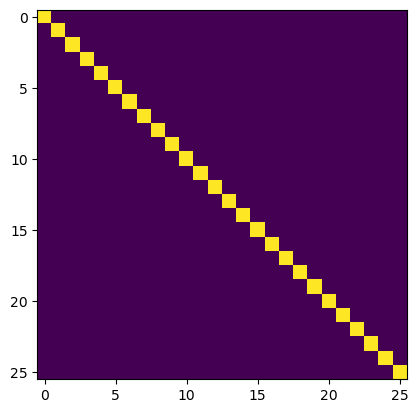

In [37]:
confusion_matrix = sklearn.metrics.confusion_matrix(true_y_orig, pred_y_orig, labels=labels)
plt.imshow(confusion_matrix)

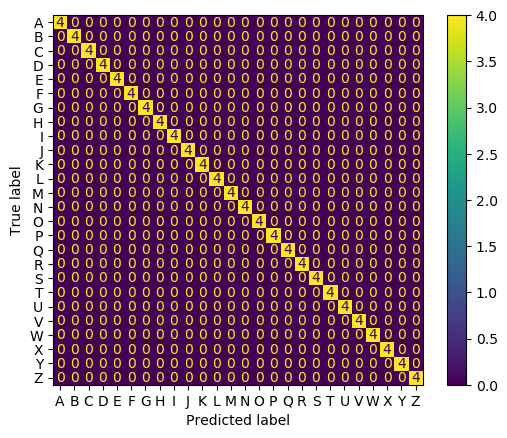

In [38]:
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=labels)
disp.plot()
plt.show()

13/13 - 0s - 205ms/epoch - 16ms/step


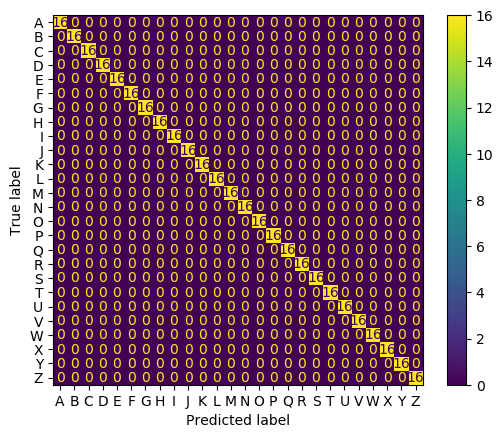

In [39]:
true_y = np.argmax(Y_dataset_all, axis=1)
pred_y_prob = conv_model.predict(X_dataset_all, verbose=2)
pred_y = np.argmax(pred_y_prob, axis=1)
confusion_matrix = sklearn.metrics.confusion_matrix(true_y, pred_y, labels=[i for i in range(NUMBER_OF_LABELS)])
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=labels)
disp.plot()
plt.show()

In [40]:
# Saving model parameters
conv_model.save('letter-recog-model.keras')  # The file needs to end with the .keras extension
conv_model.save('letter-recog-model.h5')  # The file needs to end with the .keras extension
# model = keras.models.load_model('path/to/location.keras')


# Test loading model

In [41]:
# loaded_model = models.load_model('letter-recog-model.keras')
loaded_model = models.load_model('letter-recog-model.h5')
loaded_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 80, 64, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 40, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 40, 32, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 20, 16, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 20480)             0         
                                                                 
 dropout_1 (Dropout)         (None, 20480)            

In [42]:
loaded_model.evaluate(X_dataset_all, Y_dataset_all)

13/13 [==============================] - 0s 12ms/step - loss: 7.7730e-05 - acc: 1.0000


[7.772999379085377e-05, 1.0]

# FULL DATA TRAINING

In [38]:
reset_weights(conv_model)
history_conv = conv_model.fit(X_dataset_all, Y_dataset_all,
                              epochs=20,
                              batch_size=16)

# We can also run the training by specifiying the validation split directly.
#history_conv = conv_model.fit(X_dataset, Y_dataset,
#                              validation_split=VALIDATION_SPLIT,
#                              epochs=20,
#                              batch_size=16)

Epoch 1/20
26/26 [==============================] - 1s 26ms/step - loss: 3.1142 - acc: 0.2332
Epoch 2/20
26/26 [==============================] - 1s 26ms/step - loss: 2.6303 - acc: 0.5072
Epoch 3/20
26/26 [==============================] - 1s 26ms/step - loss: 1.9639 - acc: 0.6659
Epoch 4/20
26/26 [==============================] - 1s 26ms/step - loss: 1.2748 - acc: 0.8149
Epoch 5/20
26/26 [==============================] - 1s 28ms/step - loss: 0.7242 - acc: 0.9351
Epoch 6/20
26/26 [==============================] - 1s 29ms/step - loss: 0.3837 - acc: 0.9688
Epoch 7/20
26/26 [==============================] - 1s 28ms/step - loss: 0.1911 - acc: 0.9784
Epoch 8/20
26/26 [==============================] - 1s 27ms/step - loss: 0.1088 - acc: 0.9928
Epoch 9/20
26/26 [==============================] - 1s 27ms/step - loss: 0.0521 - acc: 1.0000
Epoch 10/20
26/26 [==============================] - 1s 29ms/step - loss: 0.0291 - acc: 1.0000
Epoch 11/20
26/26 [==============================] - 1s 32m

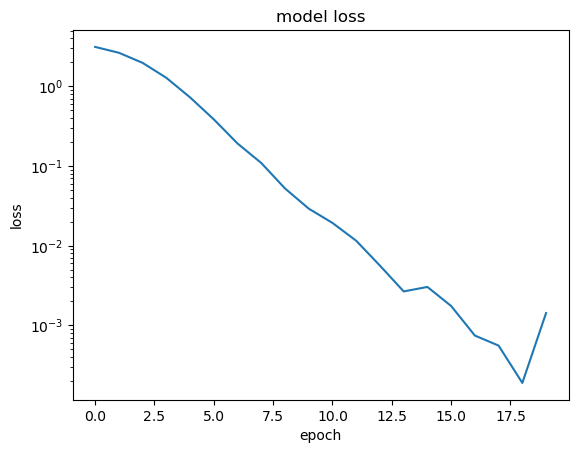

In [39]:
plt.semilogy(history_conv.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

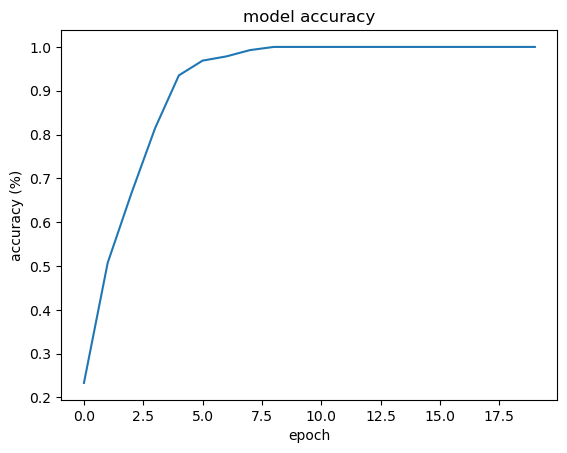

In [40]:
plt.plot(history_conv.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy (%)')
plt.xlabel('epoch')
plt.show()